# Worksheet

[FORM](https://forms.gle/5HJGU3rPkzqkbHW59)

For this worksheet you'll have to first install [pygraphviz](https://pygraphviz.github.io/documentation/stable/install.html). Then run the following cell without modifying it.

In [1]:
import numpy as np
import matplotlib as mpl
from PIL import Image as im
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from networkx import DiGraph, set_node_attributes
from networkx.drawing.nx_agraph import to_agraph
from matplotlib.colors import rgb2hex

In [35]:
import numpy as np
import matplotlib as mpl
from PIL import Image as im
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from networkx import DiGraph, set_node_attributes
from networkx.drawing.nx_agraph import to_agraph
from matplotlib.colors import rgb2hex

COLORS = np.array(['purple', 'blue'])
cvals  = [0, .5, 1]
colors = ['purple', 'white', 'blue']
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
CMAP = mpl.colors.LinearSegmentedColormap.from_list("", tuples, 100)

def unique_index(layer, node):
    return str(layer) + "_" + str(node)

class DenseGraph():

    def __init__(self, model):
        self.model = model
        self._graph = self._make_digraph()
        self._graph_original_copy = self._graph.copy()
        self._int_models = self._get_int_models()

    def get_graph(self):
        return self._graph


    def set_graph(self, graph=DiGraph()):
        self._graph = graph
        self._graph_original_copy = self._graph.copy()
        return


    def _reset(self):
        self._graph = self._graph_original_copy.copy()


    def _make_digraph(self):
        graph = DiGraph(nodesep='1', ranksep='1')

        for l in range(len(self.model.layers)):
            layer = self.model.layers[l]

            if type(layer) != keras.layers.Dense:
                raise ValueError("Unsupported Layer Type: %s Only Dense Layers are Supported", type(layer))

            if l == 0:
                for inp in range(layer._input_shape_arg[0]):
                    graph.add_node(
                        unique_index(l, inp),
                        shape="circle",
                        color="#3498db",
                        label=''
                    )
                inp += 1
            out = layer.units

            for h in range(out):
                if l == len(self.model.layers) - 1:
                    graph.add_node(
                        unique_index(l+1, h),
                        shape="circle",
                        color="#3498db",
                        label=''
                    )
                else:
                    graph.add_node(
                        unique_index(l+1, h),
                        shape="circle",
                        color="#2ecc71",
                        label=''
                    )
                for prev in range(inp):
                    graph.add_edge(
                        unique_index(l, prev),
                        unique_index(l + 1, h),
                        color="#B20000"
                    )
            inp = layer.units
        return graph


    def _get_int_models(self):
        """
        Creates a list of models where each model consists of all the layers
        (with matching weights and activations) in self.model up to a specified
        layer depth. This is important to get each node activation.
        """
        intermediate_models = []

        for l in range(len(self.model.layers)):
            int_model = keras.Sequential()
            inp = self.model.layers[0]._input_shape_arg[0]
            
            for prev_layer in range(l + 1):
                int_layer = self.model.layers[prev_layer]
                int_model.add(keras.layers.Dense(
                    int_layer.units,
                    input_dim=inp,
                    activation=int_layer.activation)
                )
                int_model.layers[prev_layer].set_weights(int_layer.get_weights())
                inp = int_layer.units
            int_model.compile(loss=self.model.loss)
            intermediate_models.append(int_model)

        return intermediate_models


    def _snap(self, filename):
        """
        Take snapshot image of the graph
        """
        out = to_agraph(self._graph)
        out.layout(prog='dot')
        out.draw(filename + '.png')
        return np.asarray(im.open(filename + '.png'))

    def animate_activations(self, X, filename='activations', duration=1000, x_color="#3498db", x_marker="o"):
        """
        Creates an animation of the graph activated by each data point
        """
        network_images = []

        predictions = [X]
        for i in range(len(self._int_models)):
            predictions.append(self._int_models[i].predict(X))
        predictions.append(self.model.predict(X))

        for i in range(len(X)):
            for l in range(len(self.model.layers)):
                if l == 0:
                    inp = self.model.layers[l]._input_shape_arg[0]
                else:
                    inp = self.model.layers[l-1].units
                for n in range(0, inp):
                    act = predictions[l][i][n]
                    index = unique_index(l, n)
                    if l == 0:
                        set_node_attributes(self._graph, {
                            index: {
                                'label' : " " + f"{act:.2f}" if act > 1 else " " + f"{act:.2f}".zfill(4) if act > 0 else f"{act:.2f}".zfill(4) if act > -1 else f"{act:.2f}"
                            }})
                    else:
                        # not used in the context of logistic regression
                        set_node_attributes(self._graph, {
                            index: {
                                'style': 'filled',
                                'color': str(rgb2hex(CMAP(act)))
                            }})

                for h in range(0, self.model.layers[l].units):
                    if l == len(self.model.layers) - 1:
                        act = predictions[l + 1][i][h]
                        index = unique_index(l + 1, h)

                        set_node_attributes(self._graph, {
                            index: {
                                'style': 'filled',
                                'color': str(rgb2hex(CMAP(act)))
                            }})

            network_images.append(self._snap(filename))
            self._reset()
        
        self._convert_gif(network_images, filename, duration)

        return
    
    def _convert_gif(self, imgs, filename, duration):
        stacked_images = []
        for img in imgs:
            stacked_images.append(im.fromarray(np.asarray(img)))

        stacked_images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=stacked_images[1:],
            loop=0,
            duration=duration
        )

        return

    def render(self, filename='graph'):
        """
        Creates a visualization of the graph for a Sequential Dense keras model
        """
        self._snap(filename)
        return

class LR():

    def __init__(self, model):
        self.model = model

    def _snap_learning(self, X, Y, filename, func):
        h = .02
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        meshData = np.c_[xx.ravel(), yy.ravel()]

        fig, ax = plt.subplots(frameon=False)
        ax.scatter(X[:, 0], X[:, 1], color=COLORS[Y].tolist(), s=100, alpha=.9)
        Z = self.model.predict(func(meshData))
        Z = np.array([z[0] for z in Z]).reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=.4, cmap=CMAP)
        fig.savefig(filename + '.png')
        plt.close()
        return np.asarray(im.open(filename + '.png'))

    def animate_learning(self, X, Y, snap_freq=10, filename='learn', duration=1000, func=lambda x: x, **kwargs):
        images = []
        if 'epochs' in kwargs:
            epochs = kwargs['epochs']
            kwargs.pop('epochs', None)
        else:
            epochs = snap_freq

        for _ in range(int(epochs / snap_freq)):
            self.model.fit(func(X), Y, epochs=snap_freq, **kwargs)
            images.append(im.fromarray(self._snap_learning(X, Y, filename, func)))

        images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=images[1:],
            loop=0,
            duration=duration
        )
        return self.model


class LR3D():

    def __init__(self, model):
        self.model = model

    def _snap_learning(self, X, Y, filename):

        weights, bias = self.model.layers[0].get_weights()
        w1, w2, w3 = weights[:, 0]
        b = bias[0]

        h = .5
        xx, yy = np.meshgrid(np.arange(-3.5, 3.5, h), np.arange(-3.5, 3.5, h))
        zz = -(w1 / w3) * xx - (w2 / w3) * yy - (b / w3)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(3, 80)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(0, 12)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=COLORS[Y].tolist(), s=30, alpha=.5)
        ax.plot_surface(xx, yy, zz, color='orange', alpha=0.3)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        fig.savefig(filename + '.png')
        plt.close()
        return np.asarray(im.open(filename + '.png'))

    def animate_learning(self, X, Y, snap_freq=10, filename='learn', duration=1000, **kwargs):
        images = []
        if 'epochs' in kwargs:
            epochs = kwargs['epochs']
            kwargs.pop('epochs', None)
        else:
            epochs = snap_freq

        for _ in range(int(epochs / snap_freq)):
            self.model.fit(X, Y, epochs=snap_freq, **kwargs)
            images.append(im.fromarray(self._snap_learning(X, Y, filename)))

        images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=images[1:],
            loop=0,
            duration=duration
        )
        return self.model


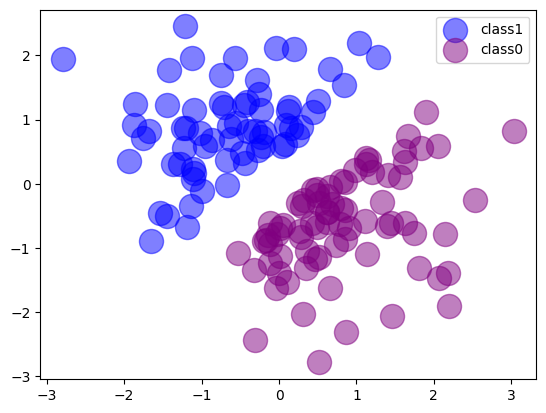

In [36]:
import sklearn.datasets as datasets

np.random.seed(1)

CENTERS = [[0, 0]]
DATA, _ = datasets.make_blobs(
        n_samples=200,
        centers=CENTERS,
        cluster_std=1,
        random_state=1
    )
w1 = 1 
w2 = -1
b = 0

X = np.array(list(filter(lambda x : w1 * x[0] + w2 * x[1] + b < -.5 or w1 * x[0] + w2 * x[1] + b > .5, DATA)))
Y = np.array([0 if w1 * x[0] + w2 * x[1] + b >= 0 else 1 for x in X])
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

In [37]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR(model)
obj.animate_learning(X, Y, 10, 'lr', 100, epochs=400)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.2518
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.2520
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 0.2542
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 0.2624
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 0.2378
Epoch 6/10


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.2538
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.2583
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.2431
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 0.2415
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.2501
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 220us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.2477
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 0.2410
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.2380
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.2424
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.2487
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.2493
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.2329
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.2293
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 0.2297
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - lo

<Sequential name=sequential_23, built=True>

## Non-Linearly Separable

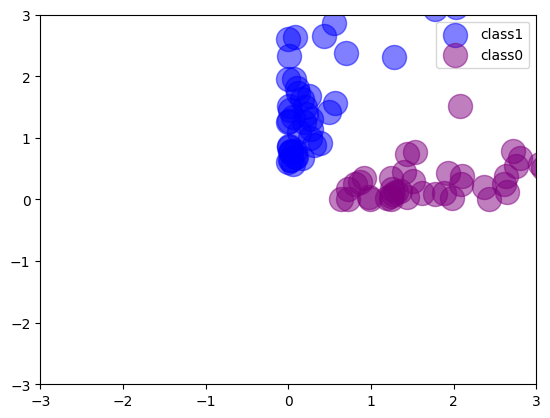

In [38]:
w1 = 1 
w2 = -1
b = 0

X = np.array(list(filter(lambda x : w1 * x[0]**2 + w2 * x[1]**2 + b < -.5 or w1 * x[0]**2 + w2 * x[1]**2 + b > .5, DATA)))
Y = np.array([0 if w1 * x[0]**2 + w2 * x[1]**2 + b >= 0 else 1 for x in X])
class1 = X[Y==1]**2
class0 = X[Y==0]**2
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.show()

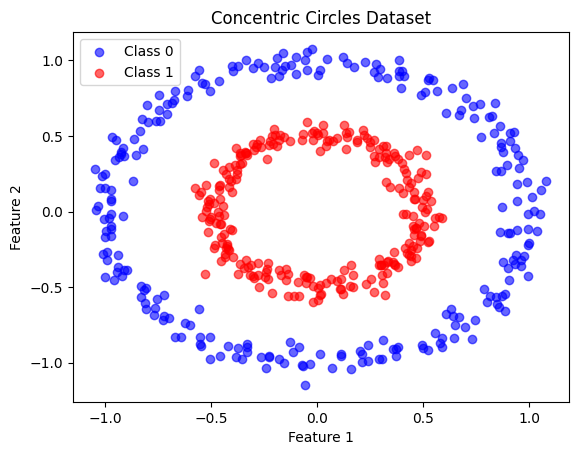

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# Generate a circular dataset
X, Y = make_circles(n_samples=500, factor=0.5, noise=0.05)

# Plotting the circular dataset
plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color='blue', label="Class 0", alpha=0.6)
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='red', label="Class 1", alpha=0.6)
plt.title("Concentric Circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [42]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR(model)
obj.animate_learning(X, Y, 10, 'my_submission', 100, epochs=100)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 0.7550
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 0.7364
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 0.7445
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.7762
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.7471
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 0.7427
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.7558
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 0.7518
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 0.7507
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 0.7423
795/795 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 0.7470
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 0.7359
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.7463
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 0.7276
Epoch 5/10
16/16 ━

<Sequential name=sequential_26, built=True>

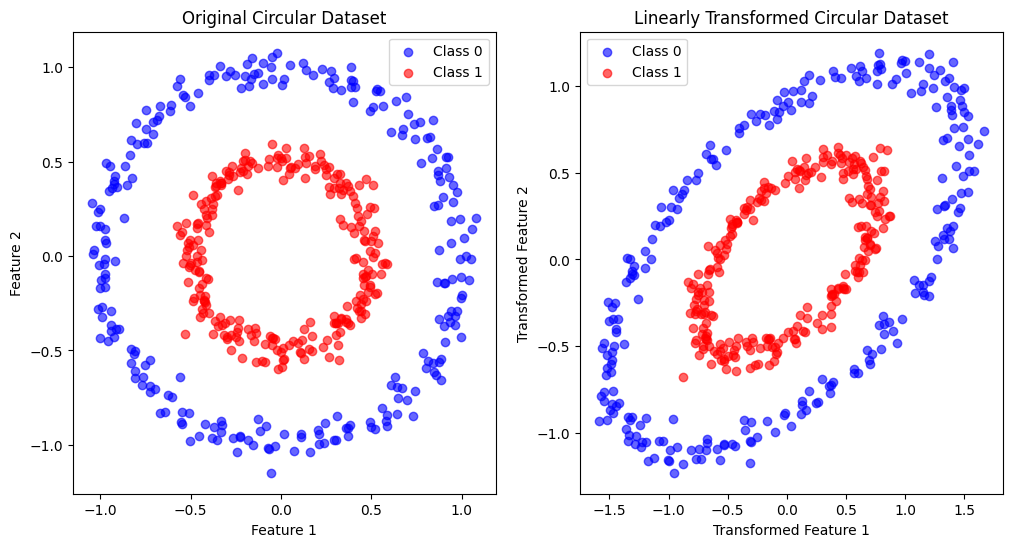

In [43]:
transformation_matrix = np.array([[1.5, 0.5], [0.2, 1]])

# Apply the transformation
X_transformed = X.dot(transformation_matrix)

# Step 3: Plot the original and transformed dataset for comparison
plt.figure(figsize=(12, 6))

# Original dataset
plt.subplot(1, 2, 1)
plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color='blue', label="Class 0", alpha=0.6)
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='red', label="Class 1", alpha=0.6)
plt.title("Original Circular Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Transformed dataset
plt.subplot(1, 2, 2)
plt.scatter(X_transformed[Y == 0][:, 0], X_transformed[Y == 0][:, 1], color='blue', label="Class 0", alpha=0.6)
plt.scatter(X_transformed[Y == 1][:, 0], X_transformed[Y == 1][:, 1], color='red', label="Class 1", alpha=0.6)
plt.title("Linearly Transformed Circular Dataset")
plt.xlabel("Transformed Feature 1")
plt.ylabel("Transformed Feature 2")
plt.legend()

plt.show()

In [39]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR(model)
obj.animate_learning(X**2, Y, 10, 'abs_lr', 100, epochs=200)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5255  
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 1.4109
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 1.3571
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 1.4973
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 1.4270
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 1.3833
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 1.4402
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1.4320
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.4494
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 1.3776
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2s 222us/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4225  
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 1.3033
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 1.3831
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 1.4191
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 501us

<Sequential name=sequential_24, built=True>

Find new features X1 and X2 that make the data linearly separable. Animate the learned decision boundary throughout gradient descent in that feature space.

In [40]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR(model)
obj.animate_learning(X, Y, 10, 'sq_lr', 100, lambda x : x**2, epochs=200)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 1.6074
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 1.6533
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 1.3919
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 1.5450
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.7097
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 1.6284
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 1.7385
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 1.4579
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 1.4156
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 1.6396
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 210us/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 1.4280
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 1.6035
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.4945
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 1.6526
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 746us

<Sequential name=sequential_25, built=True>

Animate the learned decision boundary throughout gradient descent in the original space.

## Higher Dimension

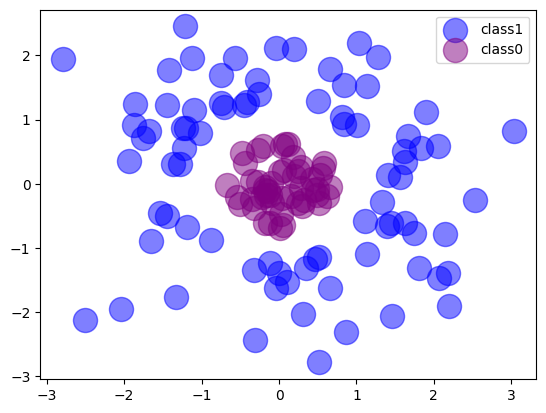

In [58]:
w1 = -1 
w2 = -1
b = 1

X = np.array(list(filter(lambda x : w1 * x[0]**2 + w2 * x[1]**2 + b < -.5 or w1 * x[0]**2 + w2 * x[1]**2 + b > .5, DATA)))
Y = np.array([0 if w1 * x[0]**2 + w2 * x[1]**2 + b >= 0 else 1 for x in X])
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

Add a new feature to X to make the data linearly separable in 3D

In [ ]:
X = np.column_stack((X, ...))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
class1 = X[Y==1]
class0 = X[Y==0]
ax.view_init(10, 80)
ax.scatter(class1[:,0], class1[:,1], class1[:,2], color=COLORS[1], s=30, alpha=.5, label='class1')
ax.scatter(class0[:,0], class0[:,1], class0[:,2], color=COLORS[0], s=30, alpha=.5, label='class0')
ax.legend()
plt.show()

Animate the learning process through gradient descent in 3D.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=3, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

...

Come up with a new example of a complex decision boundary that either requires new features or additional features or both. Animate the learned decision boundary. Also animate the graph representation of the logistic regression model as you feed it points only from class0.

Submit both gifs in the form